In [11]:
%matplotlib inline
from datacube import Datacube
import datacube

In [2]:
import numpy as np

In [3]:
dc = Datacube()

In [4]:
prod=dc.list_products()

In [5]:
query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-01-01','2018-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (30, -30)
}

In [6]:
dss = dc.find_datasets(product='s1_gamma0_geotif_scene', **query)
len(dss)

86

In [7]:
radar = dc.load(product='s1_gamma0_geotif_scene', **query)

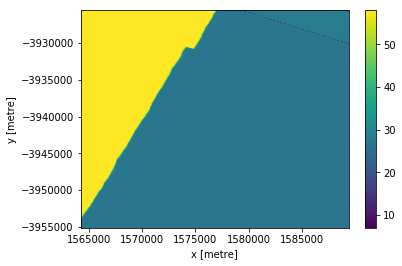

In [8]:
zeroish = 1e-4
nodata = (radar.vv <= zeroish) & (radar.vh <= zeroish)
clean = radar.copy(deep=True)
clean.vv.values[nodata.values] = np.nan
clean.vh.values[nodata.values] = np.nan
count = (~nodata).sum(dim='time')
count.plot()

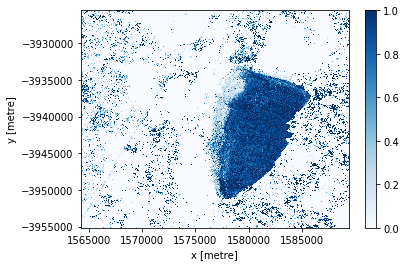

In [40]:
water = (clean.vv + clean.vh) < 0.008
dry = (clean.vv + clean.vh) > 0.1
unsure = ~water & ~dry

water = water + 0.0 # cast boolean to float
water.values[nodata.values] = np.nan
water.values[unsure.values] = np.nan
water.mean(dim='time').plot(cmap='Blues', vmin=0., vmax=1.)
water_unsure= water.mean(dim='time').copy()

In [20]:
water=water.to_dataset('wofs')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, 's1_water_exclude_unsure.nc')


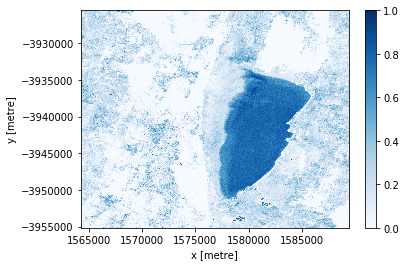

In [48]:
t1=0.01
t2=0.04
watermask = (clean.vv + clean.vh) < t1
drymask = (clean.vv + clean.vh) > t2

water = 1.-((clean.vv + clean.vh)-t1)/(t2-t1)
water.values[nodata.values] = np.nan
water.values[watermask.values]=1.
water.values[drymask.values]=0.
water.mean(dim='time').plot(cmap='Blues', vmin=0, vmax=1)
water_prob=water.mean(dim='time').copy()

In [49]:
water=water.to_dataset('wofs')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, 's1_water_prob.nc')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  """Entry point for launching an IPython kernel.


In [24]:
wofs=dc.load(product='wofs_annual_summary', **query)

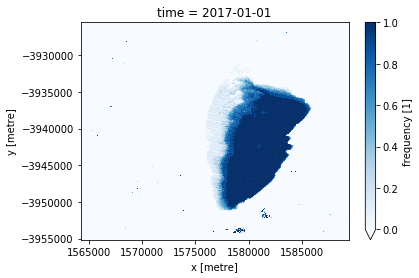

In [25]:
wofs.isel(time=0).frequency.plot(cmap='Blues', vmin=0, vmax=1)

In [26]:
wofs_freq=wofs.isel(time=0).frequency.copy()

In [42]:
wofs_freq=wofs_freq.where(wofs_freq>=0)

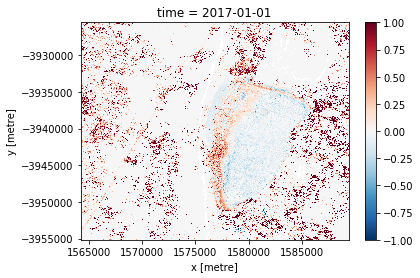

In [44]:
(water_unsure-wofs_freq).plot()

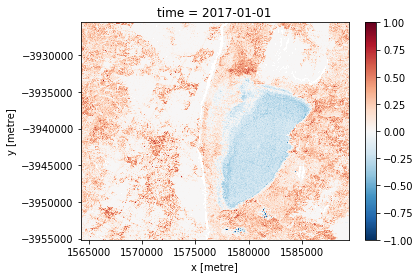

In [45]:
(water_prob-wofs_freq).plot()